# Sample based visualisation

---

This project was completed as part of the U.Mich specialisation: 'Applied Data Science with Python' on Coursera.

It builds on the work described in the paper below, about the challenges making judgements based on sample generated data (which contain an element of probability).

There are 3 solutions presented below in this notebook:

1) A 'static' chart, with a preset 'y-test value'

2) An interactive chart with a single y-test value, which can be adjusted by clicking on the chart, and adjusts the sample bar colours based on probability that the y-test value is representative of their population

3) An interactive chart with 2 y-test values, which adjusts the bar colour based on the the probability that the population mean lies between the two values


**Original paper & brief summary**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Ferreira, N., Fisher, D., & Konig, A. C. (2014, April). [Sample-oriented task-driven visualizations: allowing users to make better, more confident decisions.](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/Ferreira_Fisher_Sample_Oriented_Tasks.pdf) 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In Proceedings of the SIGCHI Conference on Human Factors in Computing Systems (pp. 571-580). ACM. ([video](https://www.youtube.com/watch?v=BI7GAs-va-Q))

*
In this [paper](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/Ferreira_Fisher_Sample_Oriented_Tasks.pdf) the authors describe the challenges users face when trying to make judgements about probabilistic data generated through samples. As an example, they look at a bar chart of four years of data (replicated below in Figure 1). Each year has a y-axis value, which is derived from a sample of a larger dataset. For instance, the first value might be the number votes in a given district or riding for 1992, with the average being around 33,000. On top of this is plotted the 95% confidence interval for the mean (see the boxplot lectures for more information, and the yerr parameter of barcharts).
*
*
A challenge that users face is that, for a given y-axis value (e.g. 42,000), it is difficult to know which x-axis values are most likely to be representative, because the confidence levels overlap and their distributions are different (the lengths of the confidence interval bars are unequal). One of the solutions the authors propose for this problem is to allow users to indicate the y-axis value of interest (e.g. 42,000) and then draw a horizontal line and color bars based on this value. So bars might be colored red if they are definitely above this value (given the confidence interval), blue if they are definitely below this value, or white if they contain this value.
*


In [1]:
# import required libraries

import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

%matplotlib notebook



In [2]:
# Use the following data for this assignment:

np.random.seed(12345)
#np.random.seed(42531)

df = pd.DataFrame([np.random.normal(32000,200000,3650), 
                   np.random.normal(43000,100000,3650), 
                   np.random.normal(43500,140000,3650), 
                   np.random.normal(48000,70000,3650)], 
                  index=[1992,1993,1994,1995])
df

,0,1,2,3,4,5,6,7,8,9,...,3640,3641,3642,3643,3644,3645,3646,3647,3648,3649
1992,-8941.531897,127788.667612,-71887.743011,-79146.060869,425156.114501,310681.166595,50581.575349,88349.230566,185804.513522,281286.947277,...,171938.760289,150650.759924,203663.976475,-377877.158072,-197214.093861,24185.008589,-56826.729535,-67319.766489,113377.299342,-4494.878538
1993,-51896.094813,198350.518755,-123518.252821,-129916.759685,216119.147314,49845.883728,149135.648505,62807.672113,23365.577348,-109686.264981,...,-44566.520071,101032.122475,117648.199945,160475.622607,-13759.888342,-37333.493572,103019.841174,179746.127403,13455.493990,34442.898855
1994,152336.932066,192947.128056,389950.263156,-93006.152024,100818.575896,5529.230706,-32989.370488,223942.967178,-66721.580898,47826.269111,...,165085.806360,74735.174090,107329.726875,199250.734156,-36792.202754,-71861.846997,26375.113219,-29328.078384,65858.761714,-91542.001049
1995,-69708.439062,-13289.977022,-30178.390991,55052.181256,152883.621657,12930.835194,63700.461932,64148.489835,-29316.268556,59645.677367,...,-13901.388118,50173.686673,53965.990717,4128.990173,72202.595138,39937.199964,139472.114293,59386.186379,73362.229590,28705.082908


In [4]:
# creates new df of key summary stats for each sample

CI = 0.95
t_critical = 1.96


data_summary = pd.DataFrame(index = df.index)
data_summary['mean'] = df.mean(axis=1)
data_summary['std'] = df.std(axis=1) # ddof=1 by default, std based on n-1
data_summary['n'] = df.count(axis=1)
data_summary['sem'] = data_summary['std']/np.sqrt(data_summary['n'])
data_summary['error_margin'] = data_summary['sem'] * t_critical
data_summary['CI_upper'] = data_summary['mean'] + data_summary['error_margin']
data_summary['CI_lower'] = data_summary['mean'] +- data_summary['error_margin']

data_summary

,mean,std,n,sem,error_margin,CI_upper,CI_lower
1992,33312.107476,200630.901553,3650,3320.866311,6508.897970,39821.005446,26803.209506
1993,41861.859541,98398.356203,3650,1628.701180,3192.254314,45054.113855,38669.605227
1994,39493.304941,140369.925240,3650,2323.419534,4553.902287,44047.207228,34939.402654
1995,47743.550969,69781.185469,3650,1155.026400,2263.851744,50007.402714,45479.699225


<IPython.core.display.Javascript object>


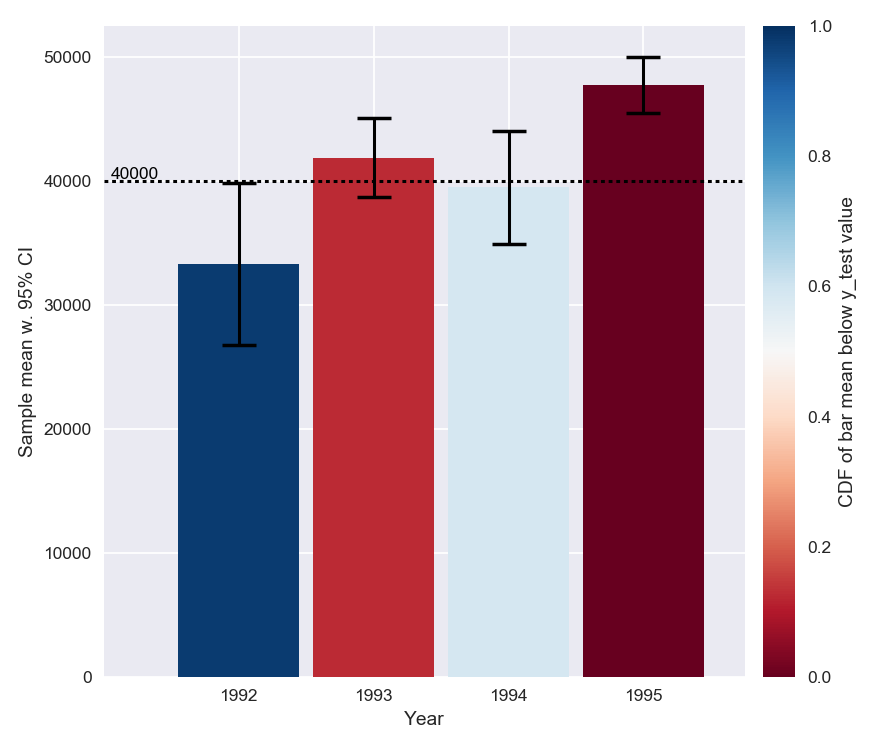

In [5]:
######################################
##### VERSION 1 - STATIC #############
######################################

############## SET Y-test value #############
# This is the y-value for the hline, and reference value
# against which bar colours are determined
y_test_1 = 40000


# setup data fields
index = data_summary.index
means = data_summary['mean']
sem = data_summary['sem']
y_err = data_summary['error_margin']

# test value, and p-scores (cdf) for samples
probs = st.norm.cdf((y_test_1 - means)/(sem))
colors = cm.RdBu(probs)

#setup figure, parameters & x-axis ticks
fig, (ax, cax) = plt.subplots(ncols = 2, figsize=(7,6), 
                              gridspec_kw = {'width_ratios':[1,0.05]})

xticks = data_summary.index
ax.set_xticks(xticks)
ax.set_xlim(min(list(xticks)) - 1, max(list(xticks))+0.75)

bar_width = 0.9
opacity = 1
error_config = {'ecolor': 'black',
                'capsize': 10,
                'capthick' : 2}

# color bar
c_bar_col = cm.ScalarMappable(cmap=cm.RdBu)
c_bar_col.set_array([])

fig.colorbar(c_bar_col,cax=cax,orientation='vertical')
cax.set_ylabel('CDF of bar mean below y_test value')



#plot chart
bars = ax.bar(index, means, bar_width, alpha = opacity,
             color = colors, yerr = y_err,
            error_kw = error_config)

#plot h line
line = ax.axhline(y_test_1, linestyle = ':',
                  color = 'black', label = 'y_test' )

ax.text(ax.get_xlim()[0]+0.05, y_test_1+500, str(int(y_test_1)), size=10,
        color = 'black', ha='left', va='center')    

# labels & axis labels
#ax.set_xticks(index, ('1992','1993','1994','1995'))
ax.set_xlabel('Year')
ax.set_ylabel('Sample mean w. 95% CI')

plt.tight_layout()
plt.show()

 

<IPython.core.display.Javascript object>


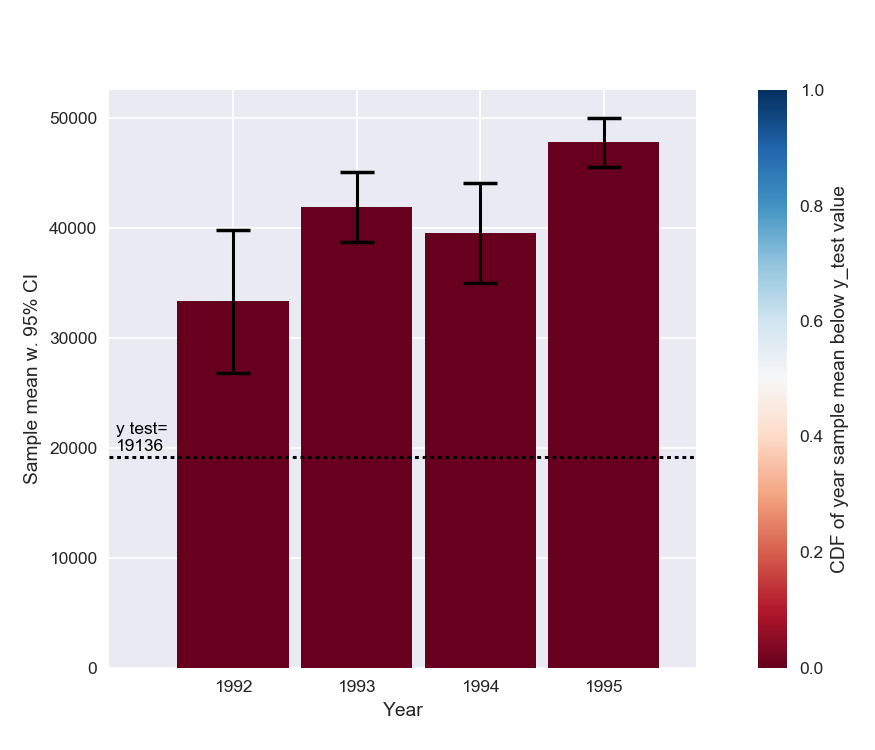

7

In [6]:
##########################################################
###### VERSION 2 - INTERACTIVE (one line) ################
##########################################################


############## SET Y-test value #############
# This is the initial y-value for the hline
y_test = 40000

# setup data fields
index = data_summary.index
means = data_summary['mean']
sem = data_summary['sem']
y_err = data_summary['error_margin']

# test value, and p-scores (cdf) for samples
probs = st.norm.cdf((y_test_1 - means)/(sem))
colors = cm.RdBu(probs)

#setup figure, ax & child ax (for color bar) and parameters
fig, (ax, cax) = plt.subplots(ncols = 2, figsize=(7,6), 
                              gridspec_kw = {'width_ratios':[1,0.05]})

# sets xticks to be index labels from data_summary df
# at sets chart limits a little below (to allow for labelling of ytest line)
xticks = data_summary.index
ax.set_xticks(xticks)
ax.set_xlim(min(list(xticks)) - 1, max(list(xticks))+0.75)

# sets some parameters for bar & error bar appearance
bar_width = 0.9
opacity = 1
error_config = {'ecolor': 'black',
                'capsize': 10,
                'capthick' : 2}

# creates, draws and labels color bar
c_bar_col = cm.ScalarMappable(cmap=cm.RdBu)
c_bar_col.set_array([])

fig.colorbar(c_bar_col,cax=cax,orientation='vertical')
cax.set_ylabel('CDF of year sample mean below y_test value')



#plots initial bar chart
bars = ax.bar(index, means, bar_width, alpha = opacity,
             color = colors, yerr = y_err,
            error_kw = error_config)

#plot initial y_test line, and labels it with value
line = ax.axhline(y_test, linestyle = ':',
                  color = 'black', label = 'y_test' )

ax.text(ax.get_xlim()[0]+0.05, y_test_1+1750, 'y test=\n'+str(int(y_test)), size=10,
        color = 'black', ha='left', va='center')    

# labels & axis labels

ax.set_xlabel('Year')
ax.set_ylabel('Sample mean w. 95% CI')

# definitiion of interactive onclick function
def onclick(event):
    plt.gcf()
    plt.gca()
    ax.cla()
    
    # set y-test value to y value of click
    y_test = event.ydata
    
    #redraws and labels new y_test line, and sets x-ticks
    line = ax.axhline(y_test, linestyle = ':',
                      color = 'black', label = 'y_test' )

    ax.text(ax.get_xlim()[0]+0.05, y_test+1750, 'y test=\n'+str(int(y_test)), size=10,
             color = 'black', ha='left', va='center')
    
    ax.set_xticks(xticks)
    ax.set_xlim(min(list(xticks)) - 1, max(list(xticks))+0.75) 
    
    # test value, and p-scores (cdf) for samples
    probs = st.norm.cdf((y_test - means)/(sem))
    colors = cm.RdBu(probs)
    
    #plot chart
    bars = ax.bar(index, means, bar_width, alpha = opacity,
                  color = colors, yerr = y_err,
                  error_kw = error_config)

    
    ax.set_xlabel('Year')
    ax.set_ylabel('Sample mean w. 95% CI')
    
    plt.draw
    
    
fig.canvas.mpl_connect('button_press_event', onclick)


<IPython.core.display.Javascript object>


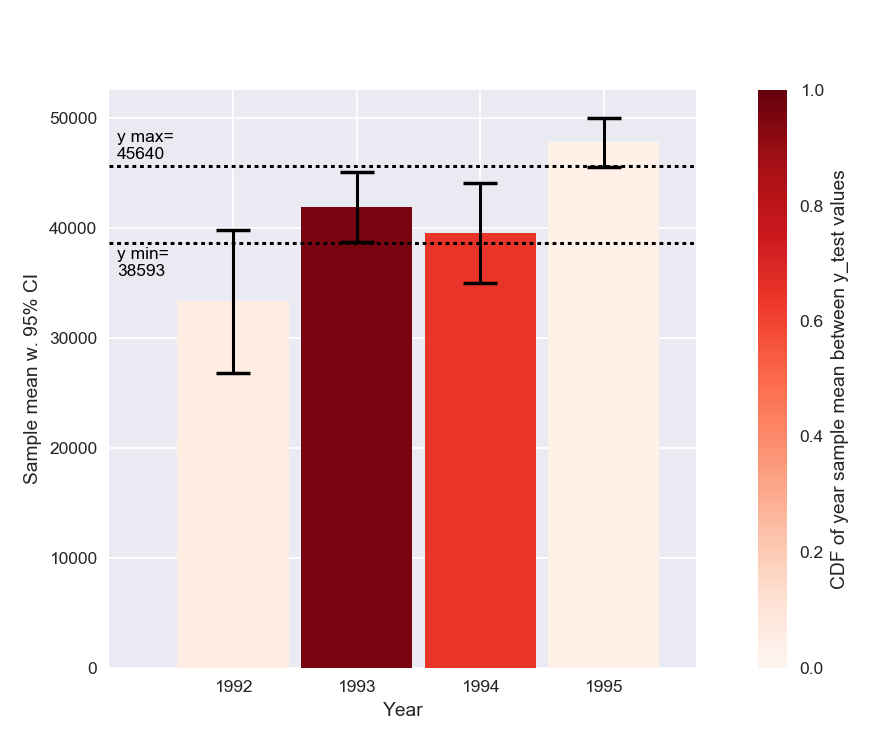

7

In [9]:
############################################
### VERSION 3 - Interactive (2 line)########
############################################

############## SET initial Y-test values #############
# set initial y_test values, and create dict of max, min, mid
y_test_1 = 44000
y_test_2 = 39000
y_test = ({'max': y_test_1, 'min': y_test_2, 'mid': (y_test_1 + y_test_2)/2})

# setup data fields
index = data_summary.index
means = data_summary['mean']
sem = data_summary['sem']
y_err = data_summary['error_margin']

# test value, and p-scores (cdf) for samples, then calculates
# prob_within as integral of cdf between lines
probs_upper = st.norm.cdf((y_test['max'] - means)/(sem))
probs_lower = st.norm.cdf((y_test['min'] - means)/(sem))
probs_within = probs_upper - probs_lower
colors = cm.Reds(probs_within)

#setup figure and parameters and xticks
fig, (ax, cax) = plt.subplots(ncols = 2, figsize=(7,6), 
                              gridspec_kw = {'width_ratios':[1,0.05]})

xticks = data_summary.index
ax.set_xticks(xticks)
ax.set_xlim(min(list(xticks)) - 1, max(list(xticks))+0.75)

bar_width = 0.9
opacity = 1
error_config = {'ecolor': 'black',
                'capsize': 10,
                'capthick' : 2}

# color bar
c_bar_col = cm.ScalarMappable(cmap=cm.Reds)
c_bar_col.set_array([])

fig.colorbar(c_bar_col,cax=cax,orientation='vertical')
cax.set_ylabel('CDF of year sample mean between y_test values')


#plot chart
bars = ax.bar(index, means, bar_width, alpha = opacity,
             color = colors, yerr = y_err,
            error_kw = error_config)

#plot h lines
line = ax.hlines([y_test['max'],y_test['min']],ax.get_xlim()[0],ax.get_xlim()[1],
                 linestyle = ':', color = 'black', label = 'y_test' )

ax.text(ax.get_xlim()[0]+0.05, y_test['max']+1750,'y max=\n'+str(y_test['max']),
        size=10,
        color = 'black', ha='left', va='center')    

ax.text(ax.get_xlim()[0]+0.05, y_test['min']-350,'y min=\n'+str(y_test['min']),
        size=10,
        color = 'black', ha='left', va='top') 


ax.set_xlabel('Year')
ax.set_ylabel('Sample mean w. 95% CI')


# define onclick interactivity
def onclick(event):
    plt.gcf()
    plt.gca()
    ax.cla()
      
    # move upper or lower line value, and adjust mid point value
    # if above mid point of lines, upper line is moved, otherwise lower.
    # mid point is reset to 'new' midpoint for new lines
    if event.ydata >= y_test['mid']:
        y_test['max'] = event.ydata
        y_test['mid'] = (y_test['max'] + y_test['min']) / 2
    else:
        y_test['min'] = event.ydata
        y_test['mid'] = (y_test['max'] + y_test['min']) / 2

  
    # draw & label lines, and set xticks
    line = ax.hlines([y_test['max'],y_test['min']],ax.get_xlim()[0],ax.get_xlim()[1],
                     linestyle = ':', color = 'black', label = 'y_test' )  
    
    ax.text(ax.get_xlim()[0]+0.3, y_test['max']+1750,
            'y max=\n'+str(int(y_test['max'])),
            size=10, color = 'black', ha='left', va='center')    

    ax.text(ax.get_xlim()[0]+0.3, y_test['min']-350,
            'y min=\n'+str(int(y_test['min'])),
            size=10, color = 'black', ha='left', va='top') 
    
    ax.set_xticks(xticks)
    ax.set_xlim(min(list(xticks)) - 1, max(list(xticks))+0.75) 
    
    # test value, and p-scores (cdf) for samples
    probs_upper = st.norm.cdf((y_test['max'] - means)/(sem))
    probs_lower = st.norm.cdf((y_test['min'] - means)/(sem))
    probs_within = probs_upper - probs_lower
    colors = cm.Reds(probs_within)
    
    #plot chart
    bars = ax.bar(index, means, bar_width, alpha = opacity,
                  color = colors, yerr = y_err,
                  error_kw = error_config)
    
    ax.set_xlabel('Year')
    ax.set_ylabel('Sample mean w. 95% CI')
    
    plt.draw

# the main call for interactivity
fig.canvas.mpl_connect('button_press_event', onclick)